# Literature comparisons

We want to make a comparisonb etween our stars and literature values. We'll do this twice:
- One comparison to LEGACY and Kages
- One comparison to published asteroseismic rotation rates

In [1]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u

sns.set_palette('colorblind')
sns.set_context('poster')

/Users/Oliver/Library/Python/3.7/lib/python/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def mnras_size(fig_width_pt, square=False):
    inches_per_pt = 1.0/72.00              # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0     # Most aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt # Figure width in inches
    if square:
        fig_height = fig_width
    else:
        fig_height = fig_width*golden_mean
    return [fig_width,fig_height]

In [3]:
ati = pd.read_csv('../data/atium.csv',index_col=0)
ati = ati[ati.eye_flag != 3]
ati = ati[np.isfinite(ati.nus.values)]
print(f'We have {len(ati)} stars with results')

We have 94 stars with results


Read in the LEGACY & Kages literature results

In [4]:
col = pd.read_csv('../data/LK_private.csv', index_col=0)
col.head(2)

,KIC,i,u_i,l_i,nus,l_nus,u_nus,nus*,l_nus*,u_nus*,P,l_P,u_P,label
0,1435467,57.190635,11.73913,8.729097,1.653867,0.26038,0.212415,1.356938,0.088360,0.106032,8.529554,0.078141,0.065117,L
1,2837475,82.474916,5.41806,7.224080,2.680312,0.15924,0.156055,2.607719,0.145851,0.145851,4.438390,0.055930,0.055930,L


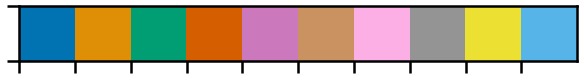

In [5]:
cmap = sns.color_palette('colorblind')
sns.palplot(cmap)

## Problem: there are a number of stars with anomalously high $\Delta P$ values. Why?

In [6]:
dP = ati['P'] / col['P']
anom = ati[dP > 2]
anom

,KIC,Teff,age,dnu,eTeff,ednu,efeh,enumax,feh,loage,...,eV2,l_P,P,u_P,l_vsini,vsini,u_vsini,rhat_flag,eye_flag,ebprp
72,5094751,5952,6.35,91.10,75,2.30,0.10,117.0,-0.08,1.05,...,0.064797,15.797263,22.863403,19.270131,0.944645,2.260598,1.570572,NaN,0,0.000552
74,6196457,5871,5.52,66.60,94,1.10,0.11,53.0,0.17,0.48,...,0.066178,13.744758,20.692243,19.234686,1.454854,3.255217,2.130367,NaN,2,0.000525
80,8349582,5699,8.03,83.60,74,1.40,0.10,90.0,0.30,0.70,...,0.061851,14.946385,41.681731,19.565467,0.394957,1.417479,0.429410,rhat_01,1,0.000754
82,8494142,6144,2.62,61.80,106,0.76,0.10,81.0,0.13,0.24,...,0.058829,4.473030,14.516515,9.885001,2.333946,5.543068,1.801705,NaN,0,0.000616
83,8554498,5945,5.60,61.98,60,0.96,0.05,76.0,0.17,0.42,...,0.051353,31.391260,35.712069,25.611323,0.716408,1.941401,1.625287,NaN,1,0.000506
86,10514430,5784,7.84,70.00,98,1.00,0.11,30.0,-0.11,0.91,...,0.043947,27.248588,53.555235,23.592684,0.325289,1.227331,0.369696,NaN,0,0.000698
89,11133306,5982,5.14,107.90,82,1.90,0.10,95.0,-0.02,0.88,...,0.070763,10.024896,24.628326,14.319218,0.698724,2.009262,0.726716,NaN,0,0.000719


In [7]:
col.loc[anom.index]

,KIC,i,u_i,l_i,nus,l_nus,u_nus,nus*,l_nus*,u_nus*,P,l_P,u_P,label
72,5094751,9.902446,55.794923,5.399509,1.224562,1.665490,11.640204,0.210589,0.211961,0.211961,3.0,2.0,38.0,K
74,6196457,11.703580,62.994447,7.199365,1.307700,2.251614,16.410810,0.265265,0.254389,0.254389,3.0,2.0,32.0,K
80,8349582,8.101434,57.598910,5.399898,1.935835,7.048428,17.016594,0.272809,0.971810,0.971810,1.0,0.0,40.0,K
82,8494142,20.853467,59.268103,5.388009,1.414066,2.720806,27.897494,0.503378,0.352202,0.352202,5.0,2.0,18.0,K
83,8554498,8.099735,62.996846,7.199640,3.483630,9.279297,31.795979,0.490832,1.210936,1.210936,1.0,0.0,8.0,K
86,10514430,4.500820,84.598756,3.599947,1.896331,3.249291,12.953234,0.148811,0.251515,0.251515,1.0,0.0,74.0,K
89,11133306,9.901683,77.397247,5.399808,2.289758,4.875265,30.341717,0.393742,0.757034,0.757034,1.0,0.0,30.0,K


### Answer: The LEGACY/Kages values are a mess

What about in $i$ and nus*?

In [44]:
di = np.rad2deg(ati['i']) / col['i']
anom = ati[di > 3]
anom['deg'] = np.rad2deg(anom['i'])
anom[['nus*','l_nus*','u_nus*','deg','P']]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,nus*,l_nus*,u_nus*,deg,P
2,0.301916,0.062498,0.056955,56.407964,31.590512
21,0.197747,0.055564,0.064428,50.519674,45.585675
27,0.257845,0.022412,0.025185,60.699675,39.171862
34,0.223742,0.064186,0.062141,59.135008,42.297177
54,0.242567,0.076364,0.083888,55.587459,38.005288
55,0.558691,0.246895,0.228684,55.629753,16.086823
72,0.386225,0.161393,0.268334,51.547414,22.863403
74,0.433971,0.193955,0.284011,52.511535,20.692243
80,0.228847,0.063764,0.069327,59.618521,41.681731
82,0.672011,0.282955,0.218429,62.794237,14.516515


In [45]:
col.loc[anom.index][['nus*','l_nus*','u_nus*','i','P']]

,nus*,l_nus*,u_nus*,i,P
2,0.183695,0.092818,0.121067,18.662207,63.006977
21,0.127046,0.134967,0.095271,9.933110,91.101253
27,0.224758,0.110131,0.107928,6.020067,51.495679
34,0.119030,0.127573,0.089881,7.826087,97.236671
54,0.097169,0.127057,0.074740,7.525084,119.113139
55,0.191644,0.280112,0.149393,15.050167,60.393729
72,0.210589,0.211961,0.211961,9.902446,3.000000
74,0.265265,0.254389,0.254389,11.703580,3.000000
80,0.272809,0.971810,0.971810,8.101434,1.000000
82,0.503378,0.352202,0.352202,20.853467,5.000000


In [9]:
dnus = ati['nus*'] / col['nus*']
anom = ati[dnus > 5]
anom['deg'] = np.rad2deg(anom.i)
anom[['nus*','l_nus*','u_nus*','deg','P']]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,nus*,l_nus*,u_nus*,deg,P
15,1.134471,0.132165,0.127663,6.893700,1.218267
36,0.691913,0.421388,0.258546,7.616282,2.004548
37,0.614729,0.503992,0.268375,8.676839,2.035735


In [10]:
col.loc[anom.index][['nus*','l_nus*','u_nus*','i','P']]

,nus*,l_nus*,u_nus*,i,P
15,0.030615,0.038460,0.023600,2.709030,378.050174
36,0.137270,0.104225,0.092066,4.816054,84.316100
37,0.083155,0.052341,0.060039,10.836120,139.186701


### Solution: Flagged them.

In [11]:
ati['exclude'] = np.zeros(len(ati))
ati.loc[dP > 2, 'exclude'] = 1
ati.loc[dnus > 5, 'exclude'] = 2

## Problem: asymmetrical errors, how do I plot these?

Let's try treating this in log space

In [12]:
ati['logP'] = np.log(ati.P)
ati['uplogP'] = np.log(ati.P + ati.u_P) - ati.logP
ati['lologP'] = ati.logP - np.log(ati.P - ati.l_P)

col['logP'] = np.log(col.P)
col['uplogP'] = np.log(col.P + col.u_P) - col.logP
col['lologP'] = col.logP - np.log(col.P - col.l_P)

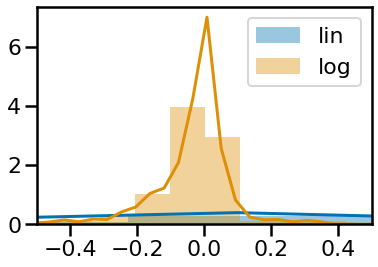

In [13]:
sns.distplot(ati.u_P.values - ati.l_P.values, label='lin')
sns.distplot(ati.uplogP.values - ati.lologP.values, label='log')
plt.xlim(-0.5, 0.5)
plt.legend()

In [14]:
ati['logi'] = np.log(ati.i)
ati['uplogi'] = np.log(ati.i + ati.u_i) - ati.logi
ati['lologi'] = ati.logi - np.log(ati.i - ati.l_i)

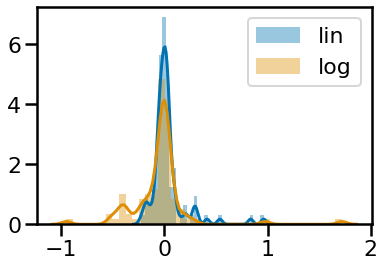

In [15]:
sns.distplot(ati.u_i.values - ati.l_i.values, label='lin')
sns.distplot(ati.uplogi.values - ati.lologi.values, label='log')
# plt.xlim(-0.5, 0.5)
plt.legend()

In [16]:
ati['lognus*'] = np.log(ati['nus*'])
ati['uplognus*'] = np.log(ati['nus*'] + ati['u_nus*']) - ati['lognus*']
ati['lolognus*'] = ati['lognus*'] - np.log(ati['nus*'] - ati['l_nus*'])

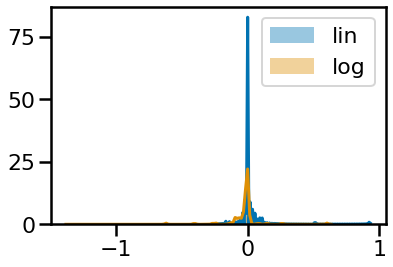

In [17]:
sns.distplot(ati['u_nus*'].values - ati['l_nus*'].values, label='lin')
sns.distplot(ati['uplognus*'].values - ati['lolognus*'].values, label='log')
# plt.xlim(-0.5, 0.5)
plt.legend()

## Solution:

- Make the P transformation in log space, take the largest error
- Take the largest error on i and nus*, make the transformation in linear space

### Distribution comparison

In [18]:
def e(a, siga, b, sigb):
    #return sigma for a/b
    rhs = (siga / b)**2 + ((a*sigb)/b**2)**2
    return np.sqrt(rhs)

In [22]:
Amlog = ati['logP'][0]
Asiglog = Aerrlog[0]

Cmlog = col['logP'][0]
Csiglog = Cerrlog[0]

aA = np.random.randn(1000)*Asiglog + Amlog
aC = np.random.randn(1000)*Csiglog + Cmlog
sns.distplot(aA)
sns.distplot(aC)

NameError: name 'Aerrlog' is not defined

In [20]:
mdPlog = Amlog/Cmlog
errlog = e(Amlog, Asiglog, Cmlog, Csiglog)
adP = np.random.randn(1000)*errlog + mdPlog
sns.distplot(adP)

NameError: name 'Amlog' is not defined

In [21]:
mdP = np.e**mdPlog
upper = np.e**(mdPlog + errlog) - mdP
lower = mdP - np.e**(mdPlog - errlog)


NameError: name 'mdPlog' is not defined

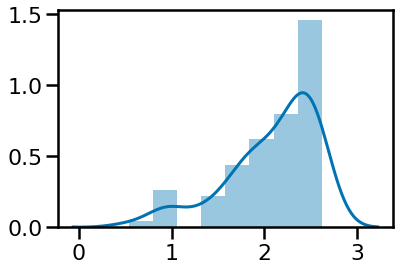

In [74]:
sns.distplot(np.e**(dPlog - errlog))

Text(0.5, 0, '$P_{\\rm rot}$ [days] (this work)')

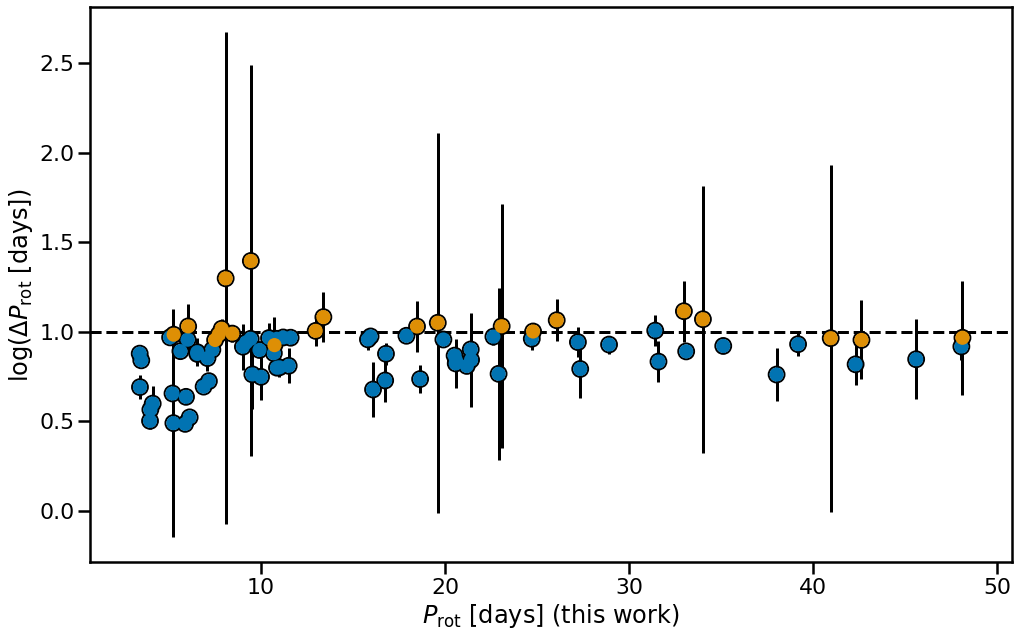

In [27]:
size=200

fig, ax2 = plt.subplots(figsize=mnras_size(595*2))

A = ati[ati.exclude == 0].copy()
C = col[ati.exclude == 0].copy()

pk = A['P'][A.source == 'K']
pl = A['P'][A.source == 'L']

ak = A['logP'][A.source == 'K']
ck = C['logP'][A.source == 'K']
al = A['logP'][A.source == 'L']
cl = C['logP'][A.source == 'L']

dPlog = A['logP'] / C['logP']
Aerrlog = A[['lologP','uplogP']].max(axis=1)
Cerrlog = C[['lologP','uplogP']].max(axis=1)
errlog = e(A['logP'], Aerrlog, C['logP'], Cerrlog)

ax2.scatter(pl, al/cl, s=size, ec='None', lw=1, zorder = 3, label='L')
ax2.scatter(pk, ak/ck, s=size, ec='None', lw=1, zorder = 3, label='K')
ax2.scatter(pk, ak/ck, s=size+50, ec='k', lw=2, fc='None', zorder = 2, label='K')
ax2.scatter(pl, al/cl, s=size+50, ec='k', lw=2, fc='None', zorder = 2, label='L')
ax2.axhline(1., ls='--', zorder=1, c='k')

ax2.errorbar(A['P'], dPlog, yerr=errlog,
            fmt='|', zorder=2, c='k')

ax2.set_ylabel(r'$\log(\Delta P_{\rm rot}$ [days])')
ax2.set_xlabel(r'$P_{\rm rot}$ [days] (this work)')


(0, 22.97918830978689)

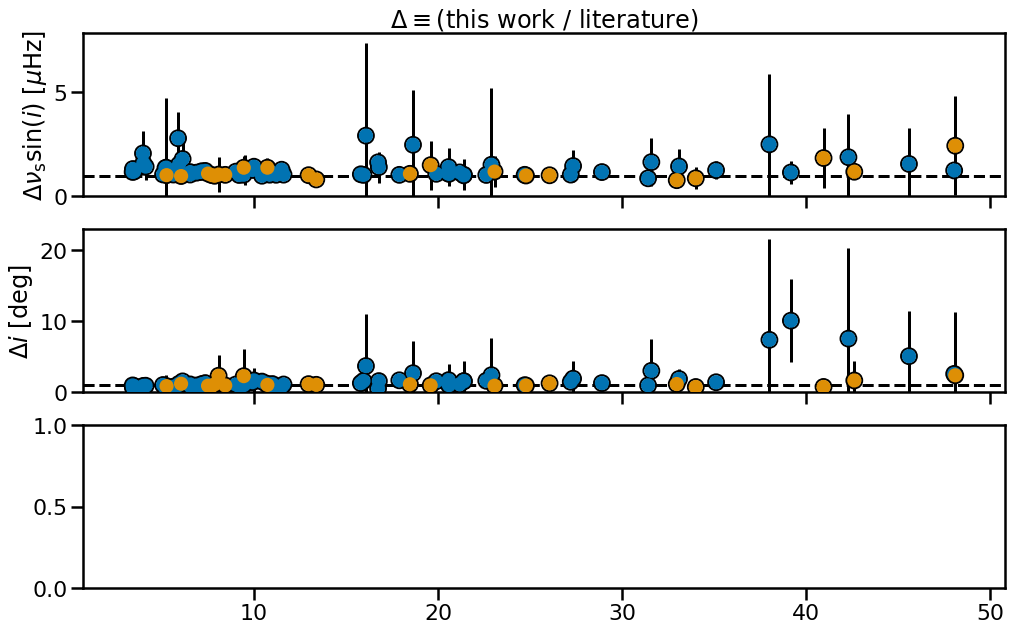

In [35]:
def e(a, siga, b, sigb):
    #return sigma for a/b
    rhs = (siga / b)**2 + (a*sigb/b**2)**2
    return np.sqrt(rhs)

A = ati[ati.exclude == 0].copy()
C = col[ati.exclude == 0].copy()

size=200
col['x'] = np.ones(len(col)) * 60

fig, axes = plt.subplots(3, 1, figsize=mnras_size(2*595), sharex=True)

ax0 = axes[0]
ax1 = axes[1]
ax2 = axes[2]

pk = A['P'][A.source == 'K']
pl = A['P'][A.source == 'L']

#Splitting
ak = A['nus*'][A.source == 'K']
ck = C['nus*'][A.source == 'K']
al = A['nus*'][A.source == 'L']
cl = C['nus*'][A.source == 'L']

Aerr = A[['l_nus*','u_nus*']].max(axis=1)
Cerr = C[['l_nus*','u_nus*']].max(axis=1)
err = e(A['nus*'],  Aerr, C['nus*'], Cerr)

ax0.scatter(pl, al/cl, s=size, ec='None', lw=1, zorder = 3, label='LEGACY')
ax0.scatter(pk, ak/ck, s=size, ec='None', lw=1, zorder = 3, label='Kages')
ax0.scatter(pk, ak/ck, s=size+50, ec='k', lw=2, fc='None', zorder = 2)
ax0.scatter(pl, al/cl, s=size+50, ec='k', lw=2, fc='None', zorder = 2)
ax0.axhline(1., ls='--', zorder=1, c='k')

ax0.errorbar(A['P'], A['nus*']/C['nus*'], yerr=err,
             fmt='|', zorder=2, c='k')

ax0.set_ylabel(r'$\Delta\nu_{\rm s}\sin(i)$ [$\mu$Hz]')
ax0.set_ylim(0)
ax0.set_title(r'$\Delta \equiv$(this work / literature)')

#inclination

ak = np.rad2deg(A['i'][A.source == 'K'])
ck = C['i'][A.source == 'K']
al = np.rad2deg(A['i'][A.source == 'L'])
cl = C['i'][A.source == 'L']
Aerr = A[['l_i','u_i']].max(axis=1)
Cerr = C[['l_i','u_i']].max(axis=1)
err = e(np.rad2deg(A['i']),  np.rad2deg(Aerr), C['i'], Cerr)

ax1.scatter(pl, al/cl, s=size, ec='None', lw=1, zorder = 3, label='L')
ax1.scatter(pk, ak/ck, s=size, ec='None', lw=1, zorder = 3, label='K')
ax1.scatter(pk, ak/ck, s=size+50, ec='k', lw=2, fc='None', zorder = 2, label='K')
ax1.scatter(pl, al/cl, s=size+50, ec='k', lw=2, fc='None', zorder = 2, label='L')
ax1.axhline(1., ls='--', zorder=1, c='k')

ax1.errorbar(A['P'], np.rad2deg(A['i'])/C['i'], yerr=err,
             fmt='|', zorder=2, c='k')
ax1.set_ylabel(r'$\Delta i$ [deg]')
ax1.set_ylim(0)


# ak = ati['P'][ati.source == 'K']
# ck = col['P'][ati.source == 'K']
# al = ati['P'][ati.source == 'L']
# cl = col['P'][ati.source == 'L']
# upper = e(ati['P'], ati['u_P'], col['P'], col['u_P'])
# lower = e(ati['P'], ati['l_P'], col['P'], col['l_P'])
# ax2.scatter(pl, al/cl, s=size, ec='None', lw=1, zorder = 3, label='L')
# ax2.scatter(pk, ak/ck, s=size, ec='None', lw=1, zorder = 3, label='K')

# ax2.scatter(pk, ak/ck, s=size+50, ec='k', lw=2, fc='None', zorder = 2, label='K')
# ax2.scatter(pl, al/cl, s=size+50, ec='k', lw=2, fc='None', zorder = 2, label='L')
# ax2.axhline(1., ls='--', zorder=1, c='k')
# ax2.errorbar(ati['P'], ati['P']/col['P'], yerr=[lower, upper],
#             fmt='|', zorder=2, c='k')
# ax2.set_ylabel(r'$\Delta P_{\rm rot}$ [days]')
# ax2.set_xlabel(r'$P_{\rm rot}$ [days] (this work)')

# # ax2.set_yscale('log')
# ax2.set_ylim(0.7, 1.3)


# plt.subplots_adjust(hspace=0)

# from mpl_toolkits.axes_grid.inset_locator import inset_axes
# col['Dnus*'] = ati['nus*'] / col['nus*']
# col['Di'] = np.rad2deg(ati['i']) / col['i']
# col['DP'] = ati['P'] / col['P']

# Violin 1
# iax0 = inset_axes(ax0, height ="100%", width="15%", loc=7)
# sns.violinplot(x='x', y='Dnus*', hue='label', 
#                inner='quartile',
#                data=col, palette=cmap, split=True, ax = iax0, legend=False)
# iax0.spines['right'].set_visible(False)
# iax0.spines['left'].set_visible(False)
# iax0.get_xaxis().set_visible(False)
# iax0.get_yaxis().set_visible(False)
# iax0.axhline(0, ls='--', c='k', zorder=0)
# iax0.legend_.remove()
# ax0.set_ylim(-1, 1.5)
# iax0.set_ylim(-1, 1.5)

# # Violin 2
# iax1 = inset_axes(ax1, height ="100%", width="15%", loc=7)
# sns.violinplot(x='x', y='Di', hue='label', data=col, 
#                 inner='quartile',
#                 palette=cmap, split=True, ax = iax1, legend=False)
# iax1.spines['right'].set_visible(False)
# iax1.spines['left'].set_visible(False)
# iax1.get_xaxis().set_visible(False)
# iax1.get_yaxis().set_visible(False)
# iax1.axhline(0, ls='--', c='k', zorder=0)
# iax1.legend_.remove()
# ax1.set_ylim(-70, 120)
# iax1.set_ylim(-70, 120)

# # Violin 2
# iax2 = inset_axes(ax2, height ="100%", width="15%", loc=7)
# sns.violinplot(x='x', y='DP', hue='label', data=col,
#                 inner='quartile',
#                 palette=cmap, split=True, ax = iax2, legend=False)
# iax2.spines['right'].set_visible(False)
# iax2.spines['left'].set_visible(False)
# iax2.get_xaxis().set_visible(False)
# iax2.get_yaxis().set_visible(False)
# iax2.axhline(0, ls='--', c='k', zorder=0)
# iax2.legend_.remove()
# ax2.set_xlim(0, 65)
# ax2.set_ylim(-100, 100)
# iax2.set_ylim(-100, 100)
# ax0.legend(ncol=2, loc='upper center')# bbox_to_anchor=[0.63,1.25,0.0,0.0])

# ax2.set_xticks(np.arange(0, 60, 5))

# plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/litcomp_alt.pdf', bbox_inches='tight', rasterized=True)

### Comparing to other published literature

In [7]:
lit = pd.read_csv('../data/literature_seismo.csv', index_col=0)
lit.head(2)

,KIC,C15_P_rot,C15_eP_rot,D16_P_rot,D16_u_eP_rot,D16_l_eP_rot,N15_P_rot,N15_u_eP_rot,N15_l_eP_rot,B18_P_rot,B18_l_eP_rot,B18_u_eP_rot
0,1435467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2837475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
len(np.isfinite(lit['D16_P_rot']))


94

In [9]:
ati.loc[np.isfinite(lit['D16_P_rot']).values]

,KIC,Teff,age,dnu,eTeff,ednu,efeh,enumax,feh,loage,...,eV2,l_P,P,u_P,l_vsini,vsini,u_vsini,rhat_flag,eye_flag,ebprp
62,12069424,5825,6.6735,103.277,50,0.021,0.03,4.6,0.10,0.7666,...,0.026682,1.114095,20.516716,1.975841,0.061279,2.112675,0.060261,rhat_1,2,0.001212
63,12069449,5750,7.3922,116.929,50,0.012,0.02,5.0,0.05,0.9103,...,0.025289,1.474881,21.178840,1.808344,0.062482,1.462994,0.063263,NaN,0,0.001060


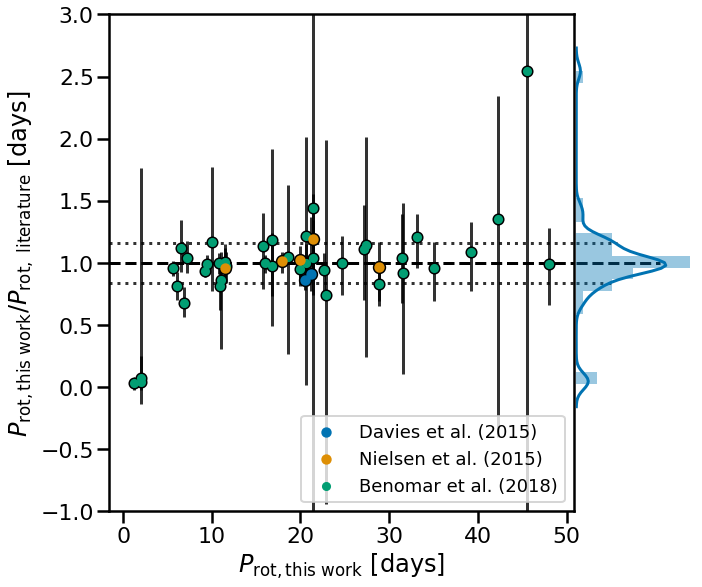

In [80]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes

np.random.seed(11)

fig, ax = plt.subplots(figsize=mnras_size(595, square=True))

outA = (ati['P'] / lit['D16_P_rot']).dropna().values
upperA = e(ati['P'], ati['u_P'], lit['D16_P_rot'], lit['D16_u_eP_rot']).dropna().values
lowerA = e(ati['P'], ati['l_P'], lit['D16_P_rot'], lit['D16_l_eP_rot']).dropna().values
xA = np.random.uniform(0.5, 1.5, len(outA))
xA = ati['P'][np.isfinite(lit['D16_P_rot']).values]
ax.scatter(xA, outA, s=70, zorder=5, label='Davies et al. (2015)')
ax.errorbar(xA, outA, yerr = [lowerA, upperA], c='k', zorder=0, fmt='|', alpha=.8)

outB = (ati['P'] / lit['N15_P_rot']).dropna().values
upperB = e(ati['P'], ati['u_P'], lit['N15_P_rot'], lit['N15_u_eP_rot']).dropna().values
lowerB = e(ati['P'], ati['l_P'], lit['N15_P_rot'], lit['N15_l_eP_rot']).dropna().values
xB = np.random.uniform(0.6, 1.4, len(outB)) + 0.3
xB = ati['P'][np.isfinite(lit['N15_P_rot']).values]
ax.scatter(xB, outB, s=70, zorder=4, label='Nielsen et al. (2015)')
ax.errorbar(xB, outB, yerr = [lowerB, upperB], c='k', zorder=0, fmt='|', alpha=.8)

outD = (ati['P'] / lit['B18_P_rot']).dropna().values
upperD = e(ati['P'], ati['u_P'], lit['B18_P_rot'], lit['B18_u_eP_rot']).dropna().values
lowerD = e(ati['P'], ati['l_P'], lit['B18_P_rot'], lit['B18_l_eP_rot']).dropna().values
xD = np.random.uniform(0.3, 1.8, len(outD)) + 1.3
xD = ati['P'][np.isfinite(lit['B18_P_rot']).values]
ax.scatter(xD, outD, s=50, zorder=2, label='Benomar et al. (2018)')
ax.errorbar(xD, outD, yerr = [lowerD, upperD], c='k', zorder=0, fmt='|', alpha=.8)

ax.scatter(xA, outA, s=70, ec='k', lw=5, fc=None)
ax.scatter(xB, outB, s=70, ec='k', lw=5, fc=None)
ax.scatter(xD, outD, s=50, ec='k', lw=5, fc=None)

ax.axhline(1., ls='--', c='k', zorder=0, lw=3)
ax.set_ylim(-1, 3)
ax.set_ylabel(r'$P_{\rm{rot, this\ work}} / P_{\rm rot,\ literature}$ [days]')
ax.set_xlabel(r'$P_{\rm{rot, this\ work}}$ [days]')

ax.legend(loc='lower right', fontsize=18)
fig.tight_layout()

left, bottom, width, height = [.9745, .133, 0.2, .8345]
iax = fig.add_axes([left, bottom, width, height])

sns.distplot(np.concatenate([outA, outB, outD]), ax=iax, vertical=True)
iax.set_ylim(-1, 3)
iax.spines['right'].set_visible(False)
iax.spines['left'].set_visible(False)
iax.spines['top'].set_visible(False)
iax.spines['bottom'].set_visible(False)
iax.get_xaxis().set_visible(False)
iax.get_yaxis().set_visible(False)
iax.axhline(1., ls='--', c='k', zorder=0, lw=3, xmax=0.7)
p = np.percentile(np.concatenate([outA, outB, outD]),[15.9, 84.1])
iax.axhline(p[0], c='k', ls=':', alpha=.8, zorder=0, lw=3, xmax=0.33)
iax.axhline(p[1], c='k', ls=':', alpha=.8, zorder=0, lw=3, xmax=0.34)

ax.axhline(p[0], c='k', ls=':', alpha=.8, zorder=0, lw=3)
ax.axhline(p[1], c='k', ls=':', alpha=.8, zorder=0, lw=3)

plt.savefig('/Users/Oliver/Dropbox/Apps/Overleaf/Malatium/Images/seis_comparison_rot_alt.pdf', rasterized=True)
plt.savefig('/Users/Oliver/Dropbox/Apps/Overleaf/Malatium/Images/seis_comparison_rot_alt.png', dpi=300)